## Does El Nino Affect Precipitation Totals and Temperature Fluctuations in the U.S.? 
### STA141B Final Project 
##### Chad Pickering & Richard Safran 
##### March 22, 2017

### Introduction

In the past several years, residents of California and other Pacific-adjacent locales have gotten accustomed to hearing about the threat of “El Nino” wreaking havoc with heavy rains, mudslides, and other rainfall-related damages and “La Nina” leaving the region cold and abnormally dry in the wintertime. The media works to spin these stories to dramatize and exaggerate what climatologists are predicting simply in order to compose a good story and get a reaction out of the general public – this is common knowledge. But, despite any bias we may have, we would like to know if El Nino and La Nina truly do affect precipitation totals in cities across the U.S., but specifically those bordering the Pacific Ocean (and close to home). We will also examine temperature trends in several U.S. cities from 1950 through 2016 to see if deviations in these are correlated with El Nino/La Nina, but mainly to see if there has been an upward trend in average recorded temperature across the country that suggests global warming/climate change, a story that, if evidence arises, should certainly be covered more in the media. In addition, we looked at where risk of storm-related damages are most prevalent in the U.S., specifically with regard to rainfall and flooding to see if frequency of these events and damages incurred merit the coverage gotten and to motivate future construction of predictive models to assist in insurance decision-making.

### Premise

Several decades ago, it was discovered that the sea surface temperature (SST) in the region off the coast of Ecuador and Peru at the equator warms and cools in a regular pattern; researchers then began studying the correlations of this warming with increased precipitation in South America, Central America, and other regions along the Pacific Rim. Coined El Nino (warm phase) and La Nina (cold phase), these are the opposite phases of the “El Nino Southern Oscillation” (ENSO) Cycle, which describes these regular fluctuations in SST. There are three main regions where the SST is measured but the common one, an average of two of the three and the most "ENSO-representative", is called “Nino 3.4”; if three-month running mean SST anomalies in this region exceed 0.5 degrees Celsius for five or more consecutive monthly periods, El Nino is confirmed. La Nina is characterized similarly, except as 0.5 degrees below average for five or more consecutive months. These observed deviations from normal are said to have impacts on ocean processes and global weather and climate, and are known as the Oceanic Nino Index (ONI). These relative fluctuations are used in our analysis to directly characterize if El Nino, La Nina, or a neutral (-0.5 < ONI < 0.5) period is present. It should be noted that every five years, the 30-year running average of the SST in the Nino 3.4 region is recalculated so that the ONI is a measure of sea surface temperature only relative to the past thirty years. This ensures that if sea surface temperature is slowly rising over time that the ONI is not also rising as well; it is periodically adjusted back to have a mean of 0.

### Data Collection 

To answer the questions of interest we gathered data from the National Oceanic and Atmospheric Administration (NOAA) in various formats.  NOAA is part of the United States Department of Commerce that collects data on the ocean and atmosphere. NOAA has domestic and international data that is collected from its domestic and international based stations that independently monitor set parameters of interest for the local region. Although the organization began in 1970, NOAA has recordings dating all the way back to 1950. Therefore, for the purposes of our project we examined ONI, temperature, precipitation, and storm events during the years of 1950 to 2016 for 16 stations across the entire United States.

The 16 cities are as follows: Sacramento, CA, Honolulu, HI, Seattle, WA, Miami, FL, Los Angeles, CA, Buffalo, NY, Colorado Springs, CO, Kansas City, MO, Portland, OR, Chicago, IL, New Orleans, LA, Minneapolis, MN, Juneau, AK, Nashville, TN, Washington D.C., and Bangor, ME. Each question is posed as in bold, and any follow-up observations we have are discussed and some images are displyed to accompany them.

In [23]:
#Needed to go through json
import pandas as pd
from pandas import Series, DataFrame, Panel
import urlparse
import numpy as np
import matplotlib.pyplot as plt
import requests
import requests_ftp
import requests_cache
import urllib2
from bs4 import BeautifulSoup
import re


#Needed to scrape ONI index
import re
import itertools

#Graphing tools
%matplotlib inline
%pylab inline
plt.rcParams['figure.figsize'] = (10, 10)

#Text Searching and Pathway Finding
import urllib2
import csv
import os
import string

#Graphing
from numpy import nan
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import seaborn as sns

#SQL
from sqlalchemy import create_engine

#HTML Pictures
from IPython.display import Image

#Cache
requests_cache.install_cache('Final_Project')

Populating the interactive namespace from numpy and matplotlib


<h3>Data Part 1: Use NOAA Climate Web API to gather precipitation, temperature average, min, and max for all available months in 1950-2016 for selected domestic stations.</h3>

The first method we used to collect data was through the NOAA’s National Centers for Environmental Information API. This database is split into seven unique sections that each houses specific information about the database, ranging from the types of parameters available to the station information.  After becoming familiar with the available parameters by exploring the various APIs, we were able to build a call function for the general summary of the month that only returned precipitation amounts and temperature minimum, maximum, and average values for a specific station. Unfortunately, the API has a maximum cap of 1000 values for a single call. This meant that we had to obtain the general summary of the month for a specific station a year at a time from the range of 1950 to 2016. After looping across each of the 16 stations for each of the 67 years, we acquired a database containing 12700 rows and 9 columns (Date, Year, Month, Station Location, Station ID, Temperature Min (Fahrenheit), Temperature Max (Fahrenheit), Temperature Avg (Fahrenheit), Cumulative Precipitation in the month). The link to the API documentation page is provided below.

https://www.ncdc.noaa.gov/cdo-web/webservices/v2

In [24]:
key = "oKEFxtWBGJZobSCrwRmtcWzyXHRSJgNR"
base_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"

def grab_data(station, Param, year):
    """
    Input: Station ID (str), Param (str), and year (int)
    Output: List of json objects for the given param in a given year
    """
    #Initialize the json object
    json_int = []
    
    #Send the request with the appropriate parementers
    response = requests.get(base_url, params = {
            "datasetid" : "GSOM", #Global Summary of the month
            "stationid" : station, #Station of interest
            "datatypeid" : Param, #Parameter of interest
            "units" : "standard", #Get readable units
            "startdate": str(year)+ "-01-01", #Start year in Jan
            "enddate" : str(year)+ "-12-31", #End year in Dec
            "limit" : 1000 #Get max amount of tokens
        }, headers = {"token":key});
    response.raise_for_status() # check for errors
    
    #Try to turn the above into a json. If there is no json object return void meaning to void the list later on.
    try:
        end = response.json()['results']
    except:
        end = "void"
    return end

In [25]:
#List of values of interest (temperature min, temperature max, temperature avg, and precipation)
Param =["TMIN", "TMAX", "TAVG", "PRCP"]

def cols_of_int(station, Param, Year_start, Year_end):
    """
    Input: Station of interest (str), parameter of interest(str), year start(int), and year end(int).
    Output: List of dictionaries with the date and the value of interest.
    """
    data = [] #intialize the dataframe
    
    #Loop over years to grab all years of interest in the relevant range
    for year in range(Year_start,Year_end+1):
        json_int = grab_data(station, Param, year) #Run the function listed above to grab the json object

        #If there is information run the following code:
        if json_int != "void":
            
            #Create a dictionary containing date and parameter value.
            for day in json_int:
                data_int = {"Date":"", Param:""}
                data_int[Param] = str(day["value"])
                data_int["Date"] = str(day["date"]).split("T")[0]            
                data.append(data_int)
    return data

In [26]:
def data_frame_creation(station,location,year_start,year_end):
    """
    Input: station (str), location (str), start year to collect data (int), and end year to collect data (int).
    Output: Dataframe containing all of the parameters of interest for a station.
    """
    T_min, T_max, T_avg, Precip = [cols_of_int(station,measure,year_start,year_end) for measure in Param] #Runs the previous function for all of the diferent parameters.
    Values = [T_min, T_max, T_avg, Precip] #Creates a list of all of the information
    
    Int_df = pd.DataFrame(T_min) #Sets up the dataframe using the first value
    
    #Loop going through the remaining parameters and adding the columns to the dataframe joined based on date. If no date supposed to return NA.
    for measures in Values[1:]:
        df = pd.DataFrame(measures)
        Int_df = pd.merge(Int_df, df, how='outer', on='Date')
        Int_df["station"] = station #Add the station information
        Int_df["location"] = location #Add the station information
    return Int_df

In [27]:
#Location of all the domestic station id's and locations of interest
domestic_station_ids = [['GHCND:USW00023271','Sacramento, CA'],['GHCND:USW00022521','Honolulu, HI'],['GHCND:USW00024233','Seattle, WA'],['GHCND:USW00012839','Miami, FL'],['GHCND:USW00023174','Los Angeles, CA'],['GHCND:USW00014733','Buffalo, NY'],['GHCND:USW00093037','Colorado Springs, CO'],['GHCND:USW00013988','Kansas City, MO'],['GHCND:USW00024229','Portland, OR'],['GHCND:USC00111577','Chicago, IL'],['GHCND:USW00012930','New Orleans, LA'],['GHCND:USW00014922','Minneapolis, MN'],['GHCND:USW00025309','Juneau, AK'],['GHCND:USW00013897','Nashville, TN'],['GHCND:USC00186350','Washington D.C.'],['GHCND:USW00014606','Bangor, ME']]

In [28]:
#This is the code that takes in all the stations of interest and goes throught he 3 functions above.
#THIS CODE TAKES ABOUT 30 min to run!!!!
list_data = []
for x in domestic_station_ids:
    list_data.append(data_frame_creation(x[0],x[1],1950,2016))

In [29]:
#Combine the seperate dataframes in the list into a signle dataframe. Ignored index for easier use later on.
final_df = pd.concat(list_data, ignore_index=True)

#This code adds the month and year on to the data frame
final_df['Month'] = [month.split("-")[1] for month in final_df['Date']]
final_df['Year'] = [year.split("-")[0] for year in final_df['Date']]
final_df["Date"] = final_df["Year"]+"-"+final_df["Month"]

In [30]:
#This is the df before the ONI index
final_df.head()

,Date,TMIN,TMAX,station,location,TAVG,PRCP,Month,Year
0,1950-01,36.6,50.4,GHCND:USW00023271,"Sacramento, CA",43.5,4.41,01,1950
1,1950-02,41.8,61.3,GHCND:USW00023271,"Sacramento, CA",51.6,3.27,02,1950
2,1950-03,43.5,63.6,GHCND:USW00023271,"Sacramento, CA",53.5,2.0,03,1950
3,1950-04,49.3,74.6,GHCND:USW00023271,"Sacramento, CA",62.0,1.04,04,1950
4,1950-05,51.1,80.5,GHCND:USW00023271,"Sacramento, CA",65.8,0.37,05,1950


<h3>Data Part 2: Extract data for the ONI index using web scraping techniques.</h3>

The second method we used to collect data was through html web scraping of NOAA’s ONI index. The ONI index is a three-month running average value that measures the deviation of the sea surface temperature from the avg in the East Central Pacific. For the purposes of our report we assigned the ONI value to the middle month within this running average. The range of this data is also from 1950 to 2016. Therefore, after acquiring the ONI value for each month in this time range we appended this column to that of the data frame in method 1. This updated 127000 x 10 data frame is what we performed our analysis on for questions 1 and 2 of the report. Below is the link to NOAA’s ONI index.

http://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ensoyears.shtml

In [31]:
#This section scrapes the ONI index page
url = "http://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ensoyears.shtml"
ONI_req = requests.get(url) #Ping the server
ONI_html = ONI_req.text #Obtain the text file of the webstie
ONI = BeautifulSoup(ONI_html, 'lxml') #Change to html code
ONI_data = ONI.findAll('table',{'border':"1"})[0]

In [32]:
#This section creates the ONI matrix.
test = ONI_data.findAll('td', {'width':'7%'})
data = []

#Eliminate the unneeded \n's and the rows containing the months found every so often in the data 
for i in test:
    value = str(i.text).strip("\n")
    if re.search("[A-z]", value, re.IGNORECASE) == None:
        data.append(value)

#Put the data into a dataframe        
subList = [data[n:n+13] for n in range(0, len(data), 13)]
col = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
data_complete = pd.DataFrame(subList, columns = col)
data_complete1 = data_complete.set_index("Year")
data_complete[["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]] = data_complete[["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]].apply(pd.to_numeric)
data_complete.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1950,-1.4,-1.2,-1.1,-1.2,-1.1,-0.9,-0.6,-0.6,-0.5,-0.6,-0.7,-0.8
1,1951,-0.8,-0.6,-0.2,0.2,0.2,0.4,0.5,0.7,0.8,0.9,0.7,0.6
2,1952,0.5,0.4,0.4,0.4,0.4,0.2,0.0,0.1,0.2,0.2,0.2,0.3
3,1953,0.5,0.6,0.7,0.7,0.7,0.7,0.7,0.7,0.8,0.8,0.8,0.7
4,1954,0.7,0.4,0.0,-0.4,-0.5,-0.5,-0.5,-0.7,-0.7,-0.6,-0.5,-0.5


In [33]:
#This section creates the Date column of the ONI index with the proper date format.
years_with_months = []
for year in data_complete['Year']:
    for num in range(1,13):
        years_no_months = np.repeat(year,12) #Need a year start for each month.
        if num <10: #Want the 0 in front of the number if it is a single digit.
            years_with_months.append(years_no_months[num-1] + '-0' +str(num))
        else:  #Don't want the 0 in front of the number if it is a single digit.
            years_with_months.append(years_no_months[num-1] + '-' +str(num))

In [34]:
del data[0::13] #Every 13 values contains the year value which I don't want. This ensures only ONI values are kept.

In [35]:
#Isolate the ONI values with the corresponding date to then merge into the main climate data from part 1
d = {'Date': years_with_months, 'ONI': data}
ONI_df = pd.DataFrame(d)
final_df_ONI = pd.merge(final_df, ONI_df[:-12], how='outer', on='Date') #Since 2017 has 1 recording want to take all values but 2017.

#Make all the columns containing numbers numeric
final_df_ONI['PRCP'] = pd.to_numeric(final_df_ONI['PRCP'], errors='coerce')
final_df_ONI['TMIN'] = pd.to_numeric(final_df_ONI['TMIN'], errors='coerce')
final_df_ONI['TMAX'] = pd.to_numeric(final_df_ONI['TMAX'], errors='coerce')
final_df_ONI['TAVG'] = pd.to_numeric(final_df_ONI['TAVG'], errors='coerce')
final_df_ONI['ONI'] = pd.to_numeric(final_df_ONI['ONI'], errors='coerce')

final_df_ONI.head()

,Date,TMIN,TMAX,station,location,TAVG,PRCP,Month,Year,ONI
0,1950-01,36.6,50.4,GHCND:USW00023271,"Sacramento, CA",43.5,4.41,01,1950,-1.4
1,1950-01,66.1,78.5,GHCND:USW00022521,"Honolulu, HI",72.3,13.24,01,1950,-1.4
2,1950-01,19.1,30.7,GHCND:USW00024233,"Seattle, WA",24.9,8.92,01,1950,-1.4
3,1950-01,67.3,78.9,GHCND:USW00012839,"Miami, FL",73.1,0.50,01,1950,-1.4
4,1950-01,40.3,56.7,GHCND:USW00023174,"Los Angeles, CA",48.5,2.54,01,1950,-1.4


### Question 1: 
#### Is there a relationship between the ONI index and accumulated monthly and annual precipitation measures in U.S. cities?


First, we need to understand the behavior of the ONI index itself, and what trends there tell us in general.

In [36]:
# ONI Index (1950-2016)
# extracts only ONI values from df and puts everything in a list
oni_valuesonly = data_complete.ix[:,'Jan':][:-1]
oni_listoflist = map(list, oni_valuesonly.values)
oni_50to16_list = array([x for y in oni_listoflist for x in y])
#oni_50to16_list = pd.to_numeric(oni_50to16_list)
dates = pd.date_range('1950-01', '2017-01', freq='M') # date range
oni_series = Series(oni_50to16_list, index=dates)
oni_temp = pd.DataFrame(oni_50to16_list.tolist())

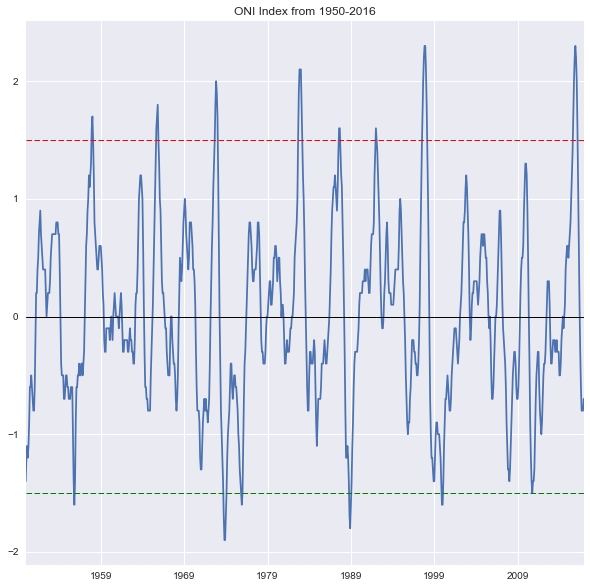

In [37]:
#Plot ONI Index over time.
oni_series.plot()
plt.axhline(1.5, color='r', linestyle='--', lw=1)
plt.axhline(0, color='black', lw=1)
plt.axhline(-1.5, color='g', linestyle='--', lw=1)
plt.title("ONI Index from 1950-2016")
plt.show()

At first glance, the ONI index looks like noise, without much pattern at all. Most of the time, ONI fluctuates moderately in any given year, usually staying between indexes -1 and 1. However, we can determine a small signal within the noise: extreme El Nino (ONI > 1.5, threshold at red line above) occurs more often than extreme La Nina (ONI < -1.5, threshold at green line above), and <b>while extreme El Nino events are no longer occurring as often, the magnitude of each of the events' peak ONIs are increasing over time</b>. With what is commonly advertised, this suggests that larger, more damaging rain events occur more often in a rainy season with higher ONIs, resulting in higher than average monthly and annual accumulated precipitation for any given city. We would like to know if precipitation (on both a monthly and annual basis) is correlated with ONI index for cities across the country. 

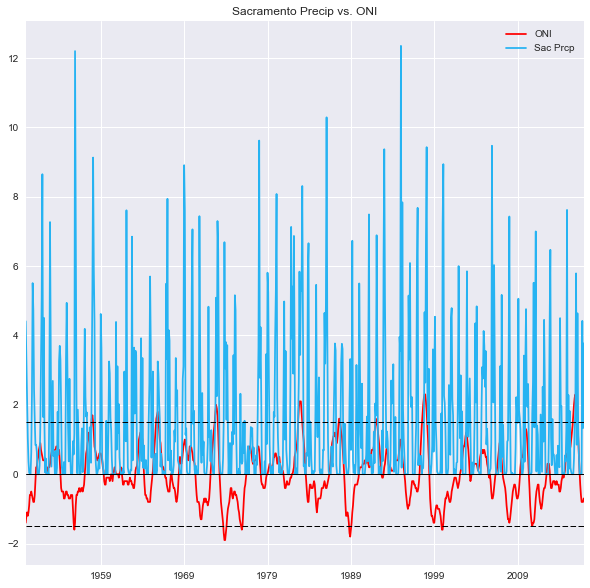

In [38]:
# Sacramento Precip vs. ONI
dates_prcpsac = pd.date_range('1950-01', '2017-01', freq='M')
sac_data = final_df_ONI.loc[final_df_ONI['location'] == "Sacramento, CA"]
sac_prcp = array(sac_data.loc[:,'PRCP'])
sac_prcp_ser = Series(sac_prcp, index=dates_prcpsac)
sac_prcp_oni = DataFrame({'ONI' : oni_series, 'Sac Prcp' : sac_prcp_ser})
sac_prcp_oni.plot(color=['red',(0.15,0.7,0.95)])
plt.axhline(1.5, color='black', linestyle='--', lw=1)
plt.axhline(0, color='black', lw=1)
plt.axhline(-1.5, color='black', linestyle='--', lw=1)
plt.title("Sacramento Precip vs. ONI")

The above plot of accumulated precipitation per month for Sacramento, CA and ONI index (red, with the same y-axis) in the range 1950-2016 is very useful for showing the most precipitation received in a peak month per year and whether large peaks roughly correspond with peaks of ONI. Using this visual methodology, there does not seem to be any obvious trend that we can identify and investigate further. Perhaps zooming in on a twenty-year period may help (below).

In [39]:
# Dates by month in range [01-1950 - 12-2016]
dates_monthly = pd.date_range('1950-01', '2017-01', freq='M')
dom_cities_list = [domestic_station_ids[idx][1] for idx in range(len(domestic_station_ids))]
split_by_city = [final_df_ONI.loc[final_df_ONI['location'] == dom_city] for dom_city in dom_cities_list] # list comprehension iterating through all cities in dom. list

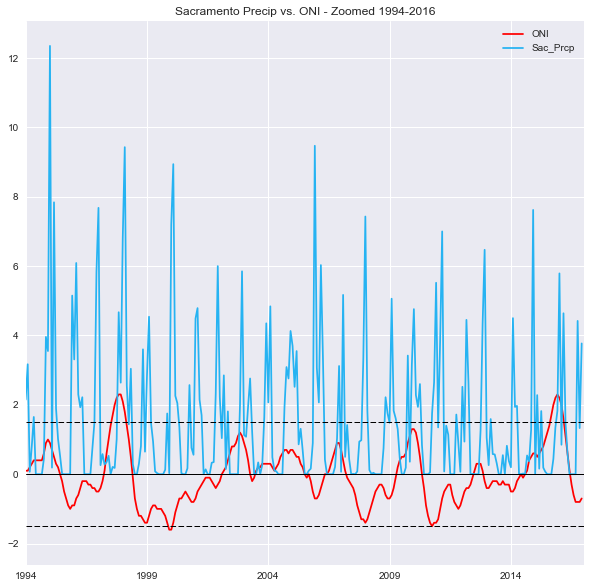

In [40]:
# Sacramento Precip vs. ONI - Zoomed 1994-2016
sac_prcp_oni = DataFrame({'ONI' : oni_series, 'Sac_Prcp' : sac_prcp_ser})
sac_prcp_oni_full = sac_prcp_oni.plot(color=['red',(0.15,0.7,0.95)])
sac_prcp_oni_full.set_xlim(pd.Timestamp('1994-01'), pd.Timestamp('2017-01'))
plt.title("Sacramento Precip vs. ONI - Zoomed 1994-2016")
plt.axhline(1.5, color='black', linestyle='--', lw=1)
plt.axhline(0, color='black', lw=1)
plt.axhline(-1.5, color='black', linestyle='--', lw=1)

Zooming in to the range 1994-2016 for Sacramento, CA certainly helps to see that the two are not obviously correlated. The one exception is the 1997-1998 water year, when the peak ONI was 2.3, monthly precipitation counts for that winter was high, and flooding was prominent in the Sacramento Valley. If these kinds of events happened more often across time, association would be far more evident, but this seems to be one of only a few isolated events. We will look at the annual accumulated precipitation versus ONI later on, as this could give a better visual if the above average rainfall was spread amongst the entire year rather than concentrated in one or two very wet months. 

/Users/Ricky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10).corr(other=<Series>)


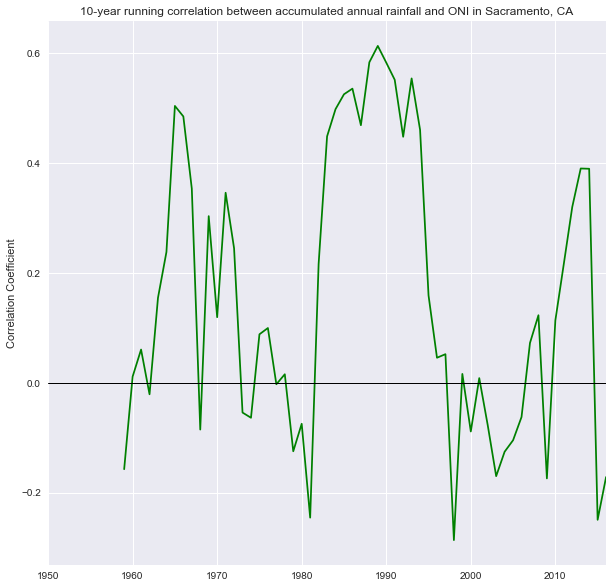

In [41]:
# 10-year running correlation between accumulated annual rainfall and ONI in Sacramento, CA
sac_prcpyear = sac_data.loc[:,['Year','PRCP']]
sac_prcpyear['PRCP'] = pd.to_numeric(sac_prcpyear['PRCP'], errors='coerce')
sac_prcp_accum = sac_prcpyear.groupby("Year").sum()
oni_accum_year = sac_data.loc[:,['Year','ONI']].groupby("Year").mean()

dates_yearly = pd.date_range('1950-01', '2017-01', freq='A')
sac_prcp_ser = Series(array(sac_prcp_accum.loc[:,'PRCP']), index=dates_yearly)
oni_ser = Series(array(oni_accum_year.loc[:,'ONI']), index=dates_yearly)

sac_prcp_oni = DataFrame({'ONI_avg' : oni_ser, 'Sac_Prcp_Total' : sac_prcp_ser})
pd.rolling_corr(sac_prcp_oni.ONI_avg, sac_prcp_oni.Sac_Prcp_Total, window=10).plot(style='-g')
plt.axhline(0, color='black', lw=1)
plt.title("10-year running correlation between accumulated annual rainfall and ONI in Sacramento, CA")
plt.ylabel("Correlation Coefficient")
plt.show()

We cannot simply draw conclusions with a rough visual comparison; we need to determine some measure of correlation coefficient over time. To directly calculate this, we generate a 10-year running correlation between annual rainfall and ONI. The trend is rather erratic, with a range that is not concentrated around some fully positive or negative region. We see a brief period of moderate correlation between about 1983 and 1995, but this does not last long. At different x-year running correlations, nothing in particular points to the expected positive correlation that is touted by climatologists and the media spin. Let's briefly take a look at accumulated rainfall per month versus ONI and see if there is any difference. 

/Users/Ricky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=36).corr(other=<Series>)


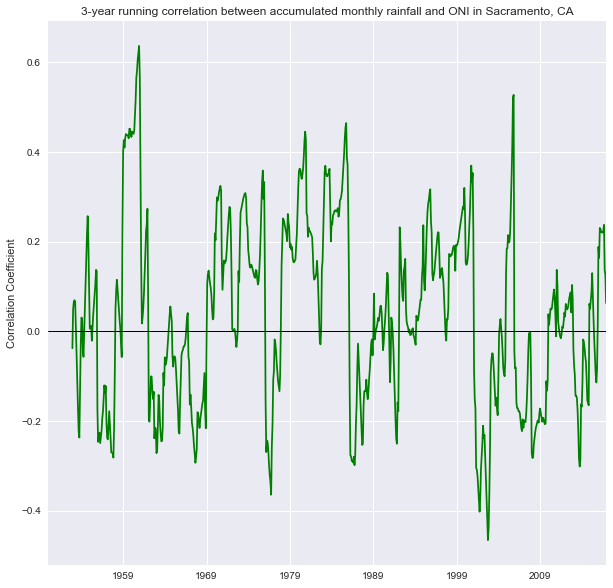

In [42]:
# 3-year running correlation between accumulated monthly rainfall and ONI in Sacramento, CA
sac_prcp_ser = Series(sac_prcp, index=dates_prcpsac)
sac_prcp_oni = DataFrame({'ONI' : oni_series, 'Sac_Prcp' : sac_prcp_ser})
pd.rolling_corr(sac_prcp_oni.ONI, sac_prcp_oni.Sac_Prcp, window=36).plot(style='-g')
plt.axhline(0, color='black', lw=1)
plt.title("3-year running correlation between accumulated monthly rainfall and ONI in Sacramento, CA")
plt.ylabel("Correlation Coefficient")
plt.show()

We can determine that a 3-year running correlation between monthly accumulated precipitation and ONI is far more erratic and noisy; no correlation is evident and we maintain our conclusion that there is no correlation between ONI and accumulated precipitation. (Note: we will calculate overall correlation coefficients later on that will be similarly discussed.)

Other domestic locations chosen for this analysis were isolated, and analogous correlation analysis was done on each - similar results were found - 10-year running correlation between annual precipitation and ONI had no purely positive or negative ranges; in fact, all of the cities chosen had a great amount of their correlations both above and below zero, just like Sacramento demonstrated above. 

Now that it has been determined that ONI has no affect on precipitation in the U.S. with the methods and procedure we employed (official coefficient coming later), we will now investigate annual accumulated precipitation trends for all 16 domestic cities, and see if a particular subset of them have changed drastically over time, and what the general trend is over time.

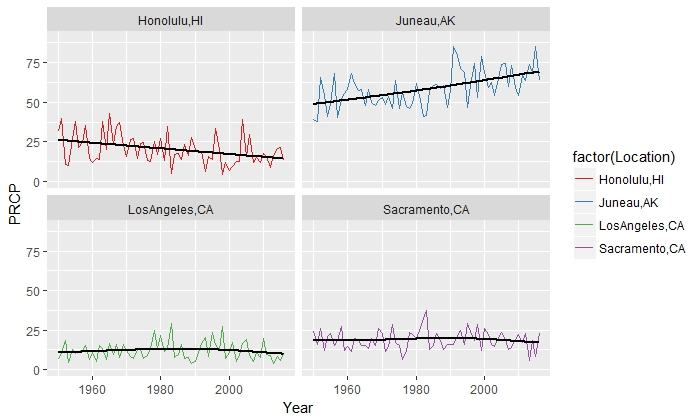

In [43]:
Image(filename = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Code/Images from R/Pacific_AnnualPrcp.jpeg")

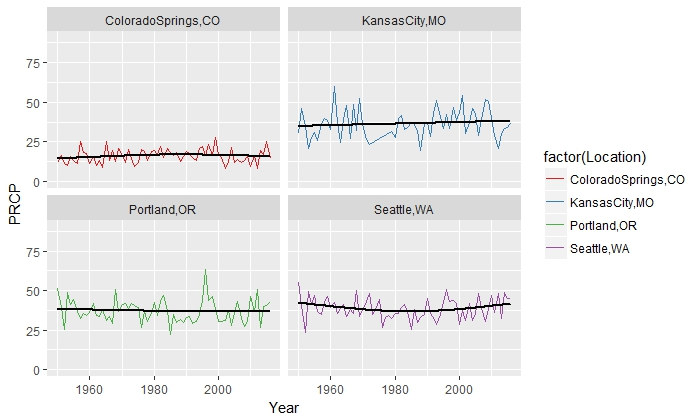

In [44]:
Image(filename = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Code/Images from R/WestCentral_AnnualPrcp.jpeg")

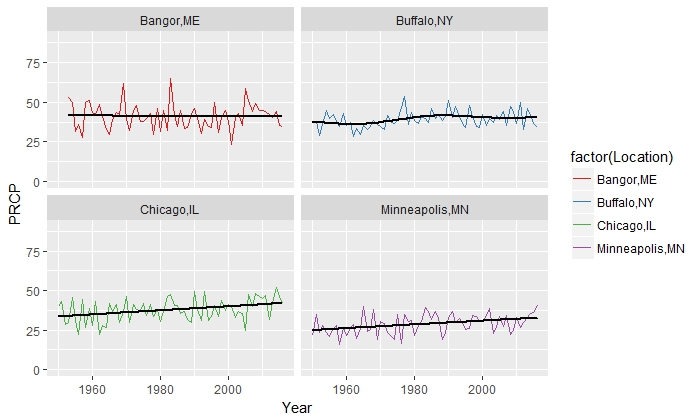

In [45]:
Image(filename = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Code/Images from R/North_AnnualPrcp.jpeg")

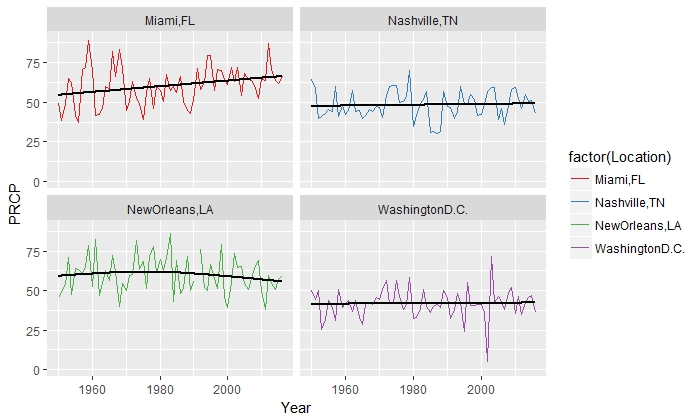

In [46]:
Image(filename = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Code/Images from R/SE_AnnualPrecip.jpeg")

Ten of the sixteen cities analyzed show <b>no significant change</b> in accumulated annual precipitation from 1950 to 2016. Two of the remaining six show a <b>marked decrease</b>, and the other four a <b>marked increase</b>. 

It is evident that New Orleans, LA, but especially Honolulu, HI has had a significant decrease in annual precipitation over time. New Orleans has more extreme weather due to occasional hurricanes, which could increase the variability in the totals, and therefore make the fitted curve less stable than it is in actuality when correcting for large anomalous storm events. Honolulu, though, shows a decrease from around a 25 inch average annual rainfall in 1950 to a 15 inch average annual rainfall in 2016 - this may be correlated with a climatic shift in the jet stream in the northern or central Pacific instigated by global warming (this warming will be investigated in the next section).

Juneau, AK showed the largest increase in annual precipitation, from 50 to 65 inches on average, which may have to do with the general jet stream shift mentioned earlier. Chicago, Minneapolis, and Miami also show distinct increases in the 66 year period. These four cities are not geographically similar, but if we can group Chicago and Minneapolis in with the Great Lakes, they all have large bodies of water nearby in common. This is probably grasping at straws, so this all suggests that geography in particular does not link all of the cities with an uptick in annual precipitation between 1950 and 2016. 

It should be noted that ONI was deemed uncorrelated in the past sections, so we are not integrating that into this analysis.

### Question 2: 
#### Is there a relationship between the ONI index and monthly temperature (minimum, maximum, average) in U.S. cities?


While in the last section we looked specifically at the most advertised ONI correlate, precipitation, and concluded that there is essentially no correlation in the way we analyzed it, we now shift our attention to temperature and whether maximum, minimum, or average temperature in these same 16 domestic cities are correlated with ONI. The well-known association with precipitation is certainly overblown, so we wonder if the association with temperature is "underblown". 

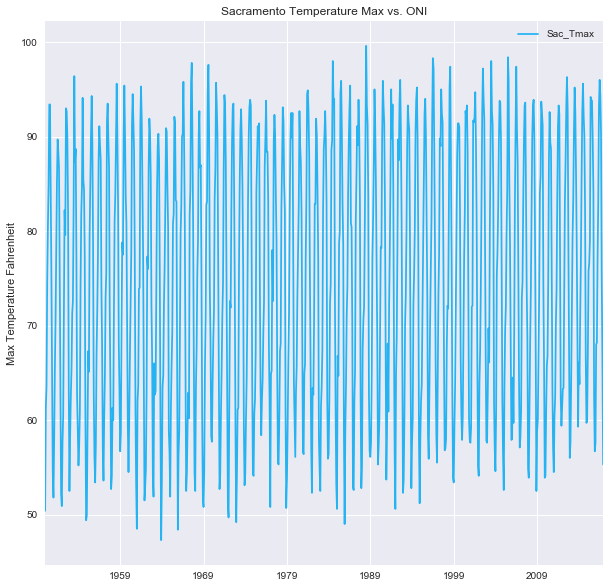

In [47]:
# Sacramento Temperature Max vs. ONI
dates_tempsac = pd.date_range('1950-01', '2017-01', freq='M')
sac_data = final_df_ONI.loc[final_df_ONI['location'] == "Sacramento, CA"]
sac_tmax = array(sac_data.loc[:,'TMAX'])
sac_tmax_ser = Series(sac_tmax, index=dates_tempsac)
sac_tmax_oni = DataFrame({'Sac_Tmax' : sac_tmax_ser})
sac_tmax_oni.plot(color=(0.15,0.7,0.95))
plt.title("Sacramento Temperature Max vs. ONI")
plt.ylabel("Max Temperature Fahrenheit")
plt.show()

We focus in on Sacramento, CA again. Above, we plot the maximum temperature over 1950-2016; seeing this ever-so-slight general upward trend motivates a separate later analysis on global warming, but we can see the behavior of seasonality in the temperatures, and how this may not be the best choice to compare against ONI. We do consider this a little later with annual averages, but this is a fitting plot to open with.

/Users/Ricky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=120).corr(other=<Series>)


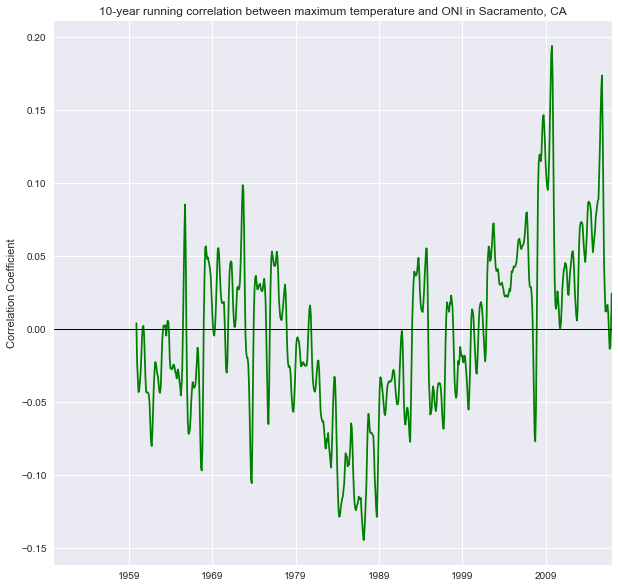

In [48]:
# 10-year running correlation between maximum temperature and ONI in Sacramento, CA
sac_tmax_ser = Series(sac_tmax, index=dates_tempsac)
sac_tmax_oni = DataFrame({'ONI' : oni_series, 'Sac_Tmax' : sac_tmax_ser})
pd.rolling_corr(sac_tmax_oni.ONI, sac_tmax_oni.Sac_Tmax, window=120).plot(style='-g')
plt.axhline(0, color='black', lw=1)
plt.title("10-year running correlation between maximum temperature and ONI in Sacramento, CA")
plt.ylabel("Correlation Coefficient")
plt.show()

Alas, just like precipitation, <b>temperature appears not to be correlated with ONI index</b>, as the 10-year running correlation hovers around zero for the entire domain. Interestingly, we see evidence of mild autocorrelation, but there's just no point analyzing this because if these were correlated it would be graphically clear. 10-year running correlation of maximum temperature and ONI was run for a set of other locations, with similar results, with and withoutmild autocorrelation. The next section displays the coefficients that have been hinted at before.

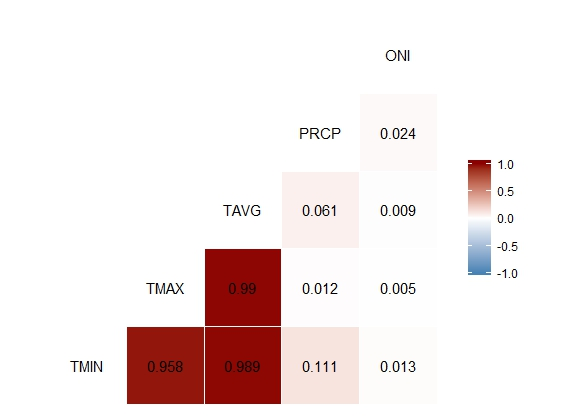

In [49]:
Image(filename = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Code/Images from R/CorrMx_Monthly.jpeg")

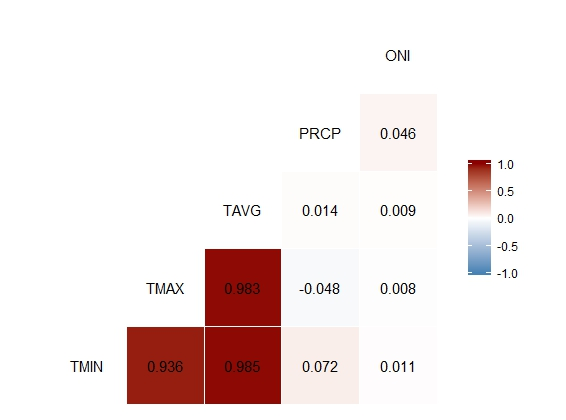

In [50]:
Image(filename = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Code/Images from R/CorrMx_AnnualAvg.jpeg")

We see that the <b>Pearson correlation coefficients for ONI and all other variables are very close to zero when using both monthly precipitation totals and annual average precipitation totals</b>. The correlation between minimum temperature and monthly precipitation has a weak positive correlation, but this might just be because locations that have snow (which is a separate variable not included in this analysis) see more rain when the minimum temperature is above 32 degrees Fahrenheit instead of snow. Additionally, but not surprisingly, these correlation matrices show an obvious strong correlation between all temperature variables, because as the maximum temperature increases, for example, minimum and average temperatures are both very likely to increase with it.

Since no significant correlations that were of interest were found, <b>we will now look at if global warming is evident</b>, at least just with the data in the sixteen U.S. cities that were chosen for this study.

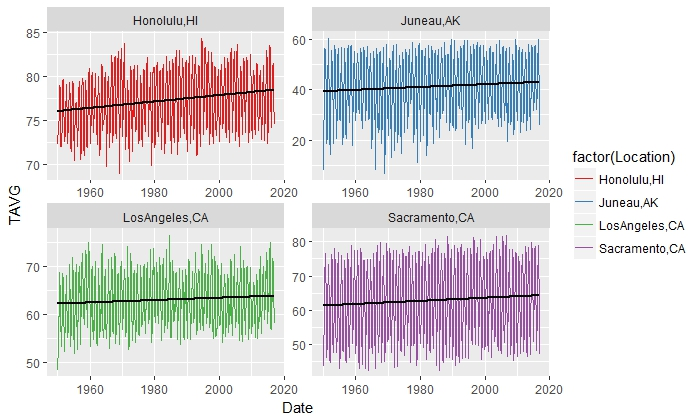

In [51]:
Image(filename = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Code/Images from R/Pacific_Temp.jpeg")

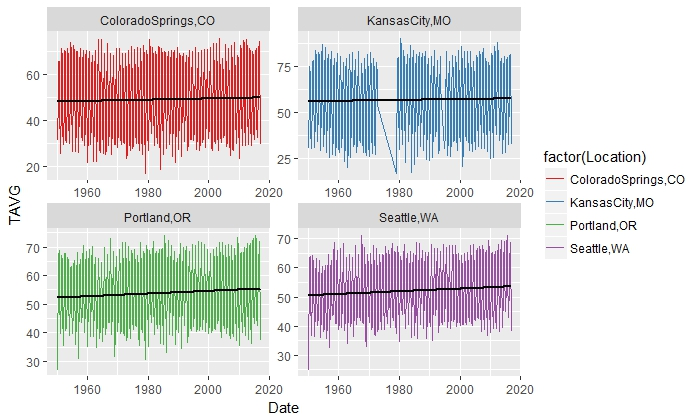

In [52]:
Image(filename = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Code/Images from R/Central_Temp.jpg")

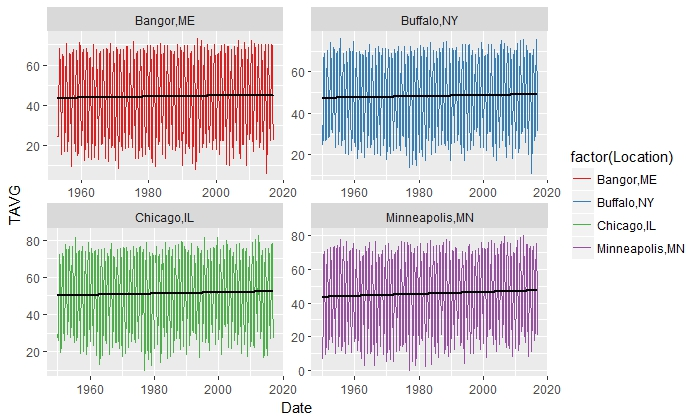

In [53]:
Image(filename = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Code/Images from R/North_Temp.jpeg")

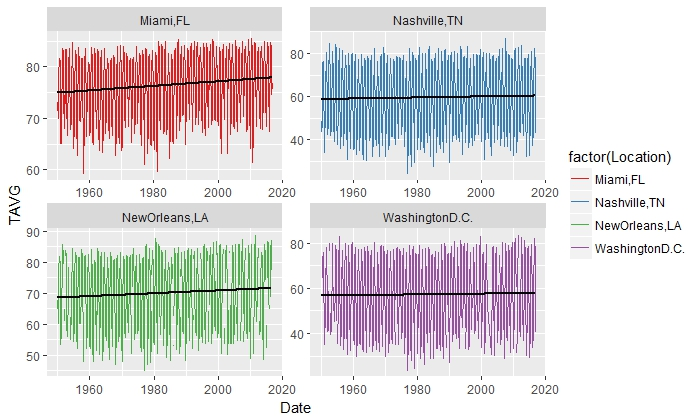

In [54]:
Image(filename = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Code/Images from R/South_Temp.jpeg")

Each of the above plots is average recorded monthly temperature from 1950 to 2016. When a linear fit is applied, <b>a slight yet significant upward trend in all 16 cities is evident</b>. This suggests global warming/climate change is indeed occurring. Data from other nations around the globe is needed for a more complete analysis, but this subset is surprisingly conclusive. 

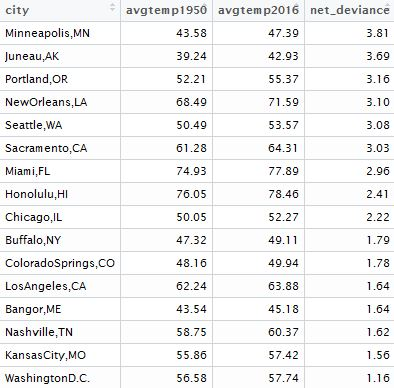

In [55]:
Image(filename = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Code/Images from R/DevianceTemp_Table.jpg")

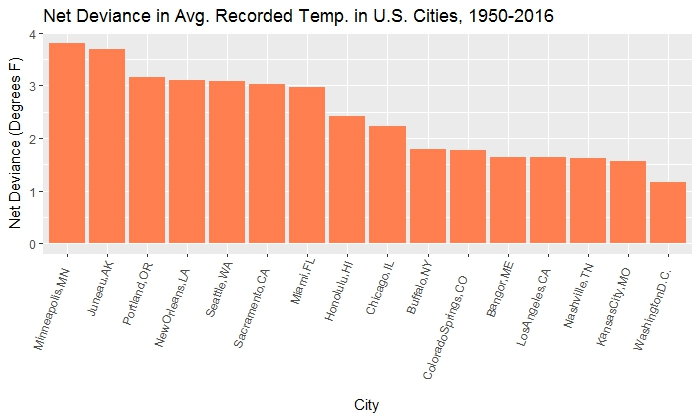

In [56]:
Image(filename = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Code/Images from R/TempDevianceBar.jpeg")

To show just how much the average recorded temperature has increased over the past 67 years, we extracted the fitted values from the linear trendline at both 1950 and 2016 and sorted the cities by the difference in the deviance between these values. <b>All sixteen cities had a deviance of between 1 and 4 degrees Fahrenheit for average recorded temperature from 1950 to 2016</b>. No obvious geographic trends are noted, e.g. higher deviances are not more common in northern cities, for example.

It is very interesting that two of the four cities that showed the most marked increases in annual precipitation from 1950 to 2016, Juneau and Minneapolis, are also the top two cities that warmed the most on average. We would need data from far more cities to confirm any additioal associations, but it seems that as colder places get warmer, precipitation that would have fallen as snow is falling as rain more often, therefore increasing rainfall totals. Other factors may play in, but this seemed most logical to conclude.

<h3>Data Part 3: Extract data from the NOAA storm database through CSV files and explore distribution of precipitation related damages in the United States</h3>

The third area we collected data from was NOAA’s storm database. Each year NOAA releases a CSV file that contains all the storms that occurred within that given year. To consolidate this data into a single workable data frame we first downloaded the CSV files on to the local computer. Next, we scraped the names of the files from the NOAA site with HTML web scraping techniques similar to method 2. Utilizing the list of names from web scraping, we then looped through each of the files and appended the CSV’s together to acquire a data frame containing all registered storm events from 1950 to 2016. This data frame contained 1.4 million storms with over 50 columns ranging from location, damage, injuries, etc. We then consolidated this data frame to 9 columns of interest from the original data frame and eliminated all rows containing NA’s. After this process we were left with approximately 500,000 thousand data points. For a quick analysis we then converted this data frame to an SQL database. Utilizing SQL queries, we were able to explore the data based on date, location and events to answer the areas of interest in question 3. The location of the storm database is given below.

https://www.ncdc.noaa.gov/stormevents/ftp.jsp

In [57]:
url = "https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
storm_req = requests.get(url) #Ping the server
storm_html = storm_req.text #Obtain the text file of the webstie
storm = BeautifulSoup(storm_html, 'lxml') #Change to html code
storm_data = storm.findAll('a')#{'href':str.startswith("StormEvents_details")})

#Obtain all the csv names to download
links = []
for line in storm_data:
    if re.search("StormEvents_details",line.text) != None:
        links.append(str(line.text)[:-3])

In [59]:
cd_path = "/Users/Ricky/Desktop/STA 141b/Github/pickeringsafran141b/Storm Data/CSV" # return path of current directory

#Open each csv and append to by columns to create a dataframe
data_storms = []
for link in links:
    filepath = os.path.join(cd_path, link) # returns path to open fname
    data_storms.append(pd.DataFrame.from_csv(filepath, index_col = None))   

/Users/Ricky/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/Ricky/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/Ricky/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [60]:
#Create a dataframe with all columns
complete_storm_df = pd.concat(data_storms, ignore_index=True) #Get rid of index values
complete_storm_df['Inj'] = complete_storm_df['INJURIES_DIRECT']+complete_storm_df['INJURIES_INDIRECT'] #Obtain an injuries column
complete_storm_df['Death'] = complete_storm_df['DEATHS_DIRECT']+complete_storm_df['DEATHS_INDIRECT'] #Obtain a deaths column

#Create a dataframe with only the columns of interest to cut down on computational intensity
interest_df = (complete_storm_df[['BEGIN_YEARMONTH', 'STATE', 'YEAR', 'MONTH_NAME', 'EVENT_TYPE','CZ_NAME','Inj','Death','DAMAGE_PROPERTY','DAMAGE_CROPS','BEGIN_LAT','BEGIN_LON']].copy())
interest_df.rename(columns={'BEGIN_YEARMONTH': 'Date', 'STATE': 'State', 'MONTH_NAME': 'Month', 'EVENT_TYPE': 'Event', 'CZ_NAME': 'City', 'MONTH_NAME': 'Month', 'DAMAGE_PROPERTY': 'Prop_Dmg', 'DAMAGE_CROPS': 'Crop_Dmg', 'YEAR':'Year','BEGIN_LAT':'Lat', 'BEGIN_LON':'Lon'}, inplace=True)
interest_df = interest_df.dropna()

#Change the date column into the right format. Do not care about the individual day since data for whole project is monthly. Looking at general trends.
dates=[]
for x in interest_df["Date"]:
    date = str(x)[:4]+'-'+str(x)[4:]
    dates.append(date)
interest_df["Date"] = dates

#Change the month column from a string to a number
month_num = []
for x in interest_df["Date"]:
    num = x.split("-")[1]
    month_num.append(num)
interest_df["Month"] = month_num

In [61]:
#This function changes the letters used to abbreviate numbers and returns the corresponding value as a float.
def change_nums_float(column):
    """
    Input: Takes in a column of a database/list as a string
    Output: Returns a list as a float
    """
    
    prop = []
    for row_int in column: #Loop over every element in the row/dataframe
        try: #Attempt to switch the string to a float of the corresponding amount.
            row = str(row_int) # convert to string so use the search function
            
            if re.search("K", row, re.IGNORECASE):
                if re.search("K", row[0], re.IGNORECASE):
                    prop.append(1000)
                else:
                    prop.append(float(row[:-1])*1000)
            
            elif re.search("H", row, re.IGNORECASE):
                prop.append(float(row[:-1])*100)
            
            elif re.search("M", row, re.IGNORECASE):
                if re.search("M", row[0], re.IGNORECASE):
                    prop.append(1000000)
                else:
                    prop.append(float(row[:-1])*1000000)
                
            elif re.search("B", row, re.IGNORECASE):
                prop.append(float(row[:-1])*1000000000) 
                
            elif re.search("T", row, re.IGNORECASE):
                prop.append(float('nan'))
            
            elif re.search("0", row[0], re.IGNORECASE):
                prop.append(float(0))    
            
            else:
                prop.append(float(row))    
    
        except: #If the above fails convert the value to nan.
            prop.append(float('nan'))
    
    return prop

In [62]:
interest_df["Prop_Dmg"] = change_nums_float(interest_df["Prop_Dmg"]) #Change all the property damage values to a float.
interest_df["Crop_Dmg"] = change_nums_float(interest_df["Crop_Dmg"]) #Change all the crop damage values to a float.
interest_df = interest_df.dropna()

In [63]:
def set_na(column):
    """
    Input: Take in a list containing strings 
    Output: Return a list containing strings
    
    Set all values in a column that are the string nan to a float equal to the value of nan.
    """
    
    values = []
    for name in column:
        name_string = str(name)
        if re.search("nan", name_string, re.IGNORECASE):
            values.append(float('NaN'))
        else:
            values.append(name_string)
    return values

In [64]:
interest_df["State"] = set_na(interest_df["State"]) #Change all the string nan values to a float nan value
interest_df["City"] = set_na(interest_df["City"]) #Change all the string nan values to a float nan value
interest_df = interest_df.dropna()

In [65]:
def lower_case_all_but_first_letter(column):
    """
    Input: Take in a list containing strings 
    Output: Return a list containing strings
    
    Purpose: Undercase a word except for the first letter.
    """
    city_list = []
    for name in column:
        city_lower = name[0] + name[1:].lower()
        city_list.append(city_lower)
    return city_list

In [66]:
interest_df["State"] = lower_case_all_but_first_letter(interest_df["State"]) #Change the city name to be lower case except for the first letter
interest_df["City"] = lower_case_all_but_first_letter(interest_df["City"]) #Change the city name to be lower case except for the first letter

In [67]:
#Dictionary of US State abbreviations
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New hampshire': 'NH',
    'New jersey': 'NJ',
    'New mexico': 'NM',
    'New york': 'NY',
    'North carolina': 'NC',
    'North dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode island': 'RI',
    'South carolina': 'SC',
    'South dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [68]:
#Dictionary of US State regions
us_state_Region = {
    'Alabama': 'South East',
    'Alaska': 'Pacific',
    'Arizona': 'West',
    'Arkansas': 'South East',
    'California': 'Pacific',
    'Colorado': 'West',
    'Connecticut': 'North East',
    'Delaware': 'North East',
    'Florida': 'South East',
    'Georgia': 'South East',
    'Hawaii': 'Pacific',
    'Idaho': 'West',
    'Illinois': 'Central',
    'Indiana': 'Central',
    'Iowa': 'Central',
    'Kansas': 'Central',
    'Kentucky': 'South East',
    'Louisiana': 'South East',
    'Maine': 'North East',
    'Maryland': 'North East',
    'Massachusetts': 'North East',
    'Michigan': 'Central',
    'Minnesota': 'Central',
    'Mississippi': 'South East',
    'Missouri': 'Central',
    'Montana': 'West',
    'Nebraska': 'Central',
    'Nevada': 'West',
    'New hampshire': 'North East',
    'New jersey': 'North East',
    'New mexico': 'West',
    'New york': 'North East',
    'North carolina': 'South East',
    'North dakota': 'Central',
    'Ohio': 'Central',
    'Oklahoma': 'Central',
    'Oregon': 'Pacific',
    'Pennsylvania': 'North East',
    'Rhode island': 'North East',
    'South carolina': 'South East',
    'South dakota': 'Central',
    'Tennessee': 'South East',
    'Texas': 'Central',
    'Utah': 'West',
    'Vermont': 'North East',
    'Virginia': 'South East',
    'Washington': 'Pacific',
    'West virginia': 'Central',
    'Wisconsin': 'Central',
    'Wyoming': 'Central',
}

In [69]:
#Put the state abbreviations on to the end of the main data frame
state_abbreviations = []
for state in interest_df["State"]:
    try:
        State_abb = us_state_abbrev[state]
        state_abbreviations.append(State_abb)
    except:
        state_abbreviations.append(float('NaN'))
interest_df["State Abb"] = state_abbreviations
interest_df = interest_df.dropna()
interest_df = interest_df.reset_index(drop=True)

In [70]:
#Change the city to follow the same format as the Web API to allow comparrisons between that dataset and this dataset.
updated_complete = []
for line in range(len(interest_df["City"])):
    updated = interest_df["City"][line]+", "+interest_df["State Abb"][line]
    updated_complete.append(updated)
interest_df["City"] = updated_complete

In [71]:
#Add regions to the main data frame to allow for subsetting by specific regions
state_regions = []
for state in interest_df["State"]:
    try:
        State_reg = us_state_Region[state]
        state_regions.append(State_reg)
    except:
        state_regions.append(float('NaN'))
interest_df["Regions"] = state_regions

In [72]:
interest_df.head()

,Date,State,Year,Month,Event,City,Inj,Death,Prop_Dmg,Crop_Dmg,Lat,Lon,State Abb,Regions
0,1950-04,Oklahoma,1950,04,Tornado,"Washita, OK",0,0,250000.0,0.0,35.12,-99.20,OK,Central
1,1950-04,Texas,1950,04,Tornado,"Comanche, TX",0,0,25000.0,0.0,31.90,-98.60,TX,Central
2,1950-07,Pennsylvania,1950,07,Tornado,"Lehigh, PA",2,0,25000.0,0.0,40.58,-75.70,PA,North East
3,1950-07,Pennsylvania,1950,07,Tornado,"Dauphin, PA",0,0,2500.0,0.0,40.60,-76.75,PA,North East
4,1950-07,Pennsylvania,1950,07,Tornado,"Crawford, PA",0,0,2500.0,0.0,41.63,-79.68,PA,North East


<h4>Use SQL to quickly examine the database:</h4>

In [73]:
#Change DataFrame to SQL Database for ease of use querying
engine = create_engine('sqlite:///:memory:')
interest_df.to_sql('storm_data', engine)

In [74]:
#Look at the sql database
storm_sql = pd.read_sql_table('storm_data', engine, index_col = "index")
storm_sql.head()

,Date,State,Year,Month,Event,City,Inj,Death,Prop_Dmg,Crop_Dmg,Lat,Lon,State Abb,Regions
index,,,,,,,,,,,,,,
0,1950-04,Oklahoma,1950,04,Tornado,"Washita, OK",0,0,250000.0,0.0,35.12,-99.20,OK,Central
1,1950-04,Texas,1950,04,Tornado,"Comanche, TX",0,0,25000.0,0.0,31.90,-98.60,TX,Central
2,1950-07,Pennsylvania,1950,07,Tornado,"Lehigh, PA",2,0,25000.0,0.0,40.58,-75.70,PA,North East
3,1950-07,Pennsylvania,1950,07,Tornado,"Dauphin, PA",0,0,2500.0,0.0,40.60,-76.75,PA,North East
4,1950-07,Pennsylvania,1950,07,Tornado,"Crawford, PA",0,0,2500.0,0.0,41.63,-79.68,PA,North East


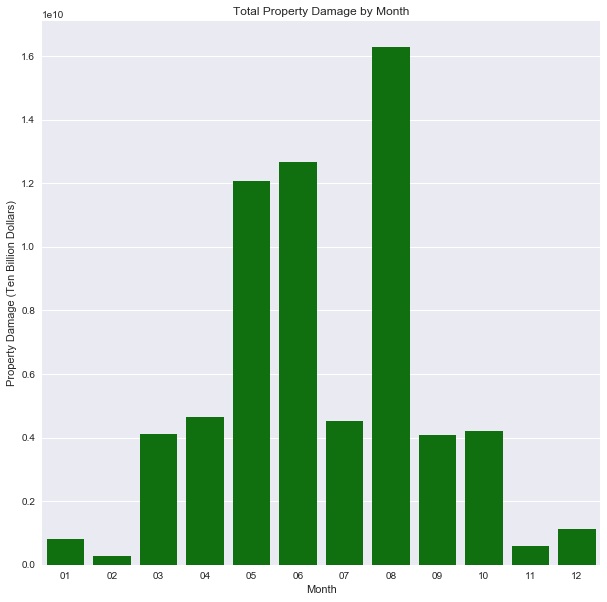

In [75]:
#Obtain the query and plot that looks at each month and acquires the total damages in that month for all years combined.
Month_dmg = pd.read_sql_query('SELECT Month, SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total Dmg" FROM storm_data \
                    WHERE Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning" \
                    GROUP BY Month', engine)
sns.barplot(x=Month_dmg['Month'], y=Month_dmg["Total Dmg"],color="green")
plt.title("Total Property Damage by Month")
plt.ylabel("Property Damage (Ten Billion Dollars)")
plt.show()

We categorized total property damages as both property damages and crop damages. Additionally, we chose storm events that could potentially be caused by precipitation. We then examined the distribution of total damages stratified by month to see if some were more susceptible to storm damages than others. Given the graph above there is an obvious correlation between total damages and month where the spring/summer months have significantly more damage than other months, excluding July. A possible reason for spring/summer months having more damage is the higher prevalence of storms during this time period. Another possible explanation could be the higher prevalence of floods during these months, where floods cause the most damage on average. Additionally, crop damages are uncommon to impossible in winter months, which significantly lessens these month's damage totals.

In [76]:
#Reports prior to 1990 are sparse so only take after 1990. Look at events that could be cause by rain. Break apart by region.
Pacific_dmg = pd.read_sql_query('SELECT Year, SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total Dmg" FROM storm_data \
                    WHERE (Regions == "Pacific" OR Regions == "West") AND (YEAR >=1990) AND (Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning") \
                    GROUP BY Year', engine)

In [77]:
#Reports prior to 1990 are sparse so only take after 1990. Look at events that could be cause by rain. Break apart by region.
Central_dmg = pd.read_sql_query('SELECT Year, SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total Dmg" FROM storm_data \
                    WHERE (Regions == "Central") AND (YEAR >=1990) AND (Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning") \
                    GROUP BY Year', engine)

In [78]:
#Reports prior to 1990 are sparse so only take after 1990. Look at events that could be cause by rain. Break apart by region.
SE_dmg = pd.read_sql_query('SELECT Year, SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total Dmg" FROM storm_data \
                    WHERE (Regions == "South East") AND (YEAR >=1990) AND (Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning") \
                    GROUP BY Year', engine)

In [79]:
#Reports prior to 1990 are sparse so only take after 1990. Look at events that could be cause by rain. Break apart by region.
NE_dmg = pd.read_sql_query('SELECT Year, SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total Dmg" FROM storm_data \
                    WHERE (Regions == "North East") AND (YEAR >=1990) AND (Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning") \
                    GROUP BY Year', engine)

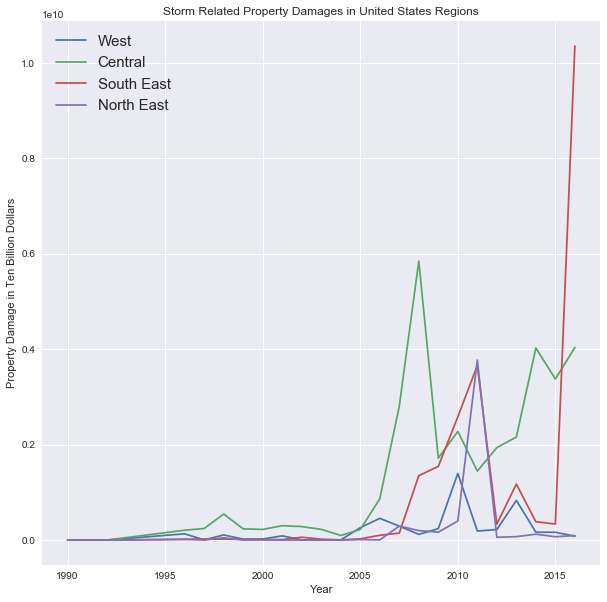

In [80]:
#Graph the 4 regions against eachother with total damage on the y and year on the x.
sns.set_style("darkgrid")
plt.plot(Pacific_dmg["Year"], Pacific_dmg["Total Dmg"])
plt.plot(Central_dmg["Year"], Central_dmg["Total Dmg"])
plt.plot(SE_dmg["Year"], SE_dmg["Total Dmg"])
plt.plot(NE_dmg["Year"], NE_dmg["Total Dmg"])

plt.title("Storm Related Property Damages in United States Regions")
plt.xlabel("Year")
plt.ylabel("Property Damage in Ten Billion Dollars")
plt.legend(('West', 'Central', 'South East', 'North East'),
           loc='upper left',
           fontsize=15)
plt.show()

Storm recordings prior to 1990 only record specific events, such as tornados, and therefore there are few recordings of precipitation related storms prior to this point. Therefore, we have restricted the domain to 1990 through 2016 and split the U.S. by region (West, Central, Southeast, and Northeast). There is a lot of variability in each of the four regions, which is to be expected since storms happen irregularly and high damaging storms are even more sporadic. Therefore, in any given year, the amount of damages can fluctuate dramatically. On average the central region has the most damages, which can be explained by the sheer size of the region. Therefore, if a storm were to occur randomly in the US it would on average occur a majority of the time in the central region if there was a uniform chance of a storm occuring in any location in the country. Another reason could be the prevalence of high impact storms in the central time zone caused from older infrastructure being more affected by the elements or the greater severity/high impact of these storms. Out of all the regions, the west has the least amount of storm damages on average as well as the least fluctuations. The reason for this could be that the west has better infrastructure, less severe storms, and/or fewer storms on average.

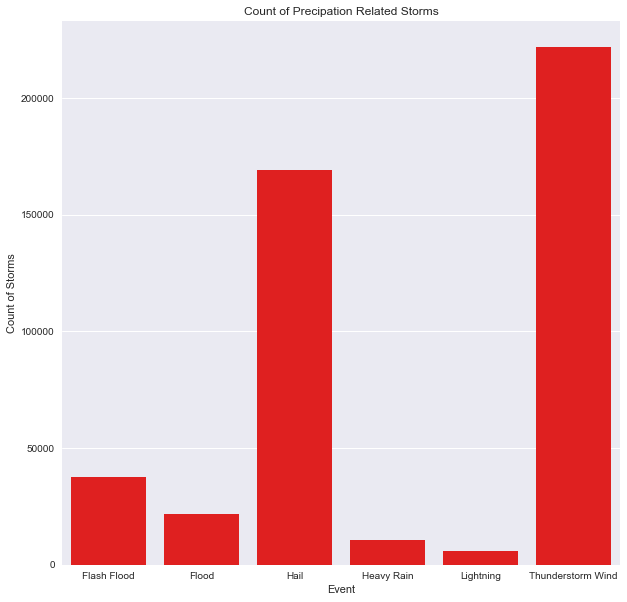

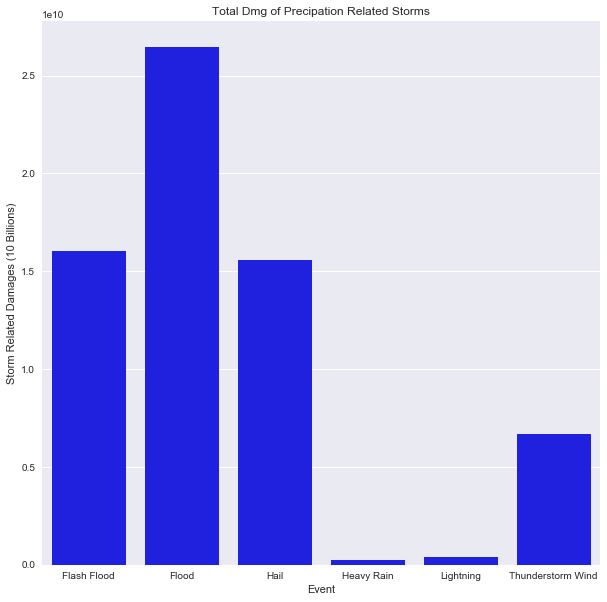

In [81]:
#Look at counts for type of events that caused damages that could be caused by rain.
all_rain_storms = pd.read_sql_query('SELECT Event, Count(Event), SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total_Dmg" FROM storm_data \
                    WHERE (Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning") \
                    GROUP BY Event', engine)

#Bar plot of counts
sns.barplot(x=all_rain_storms['Event'], y=all_rain_storms["Count(Event)"],color="red")
plt.title("Count of Precipation Related Storms")
plt.ylabel("Count of Storms")
plt.show()

#Bar plot for amount of total damages that type of storm caused.
sns.barplot(x=all_rain_storms['Event'], y=all_rain_storms["Total_Dmg"],color="blue")
plt.title("Total Dmg of Precipation Related Storms")
plt.ylabel("Storm Related Damages (10 Billions)")
plt.show()

Based on the plots it is apparent that the most reported storms are thunderstorms, yet these only account for a small fraction of the overall amount of damages. Additionally, hail follows the same pattern as thunderstorms, yet the amount of damages hail causes is still substantial, at approximately 25% of all damages incurred. On the other extreme, floods and flash floods are rare events, yet they by far cause the most damages out of any event. Thus, we wanted to examine the prevalence of high impact storms based on different events.  

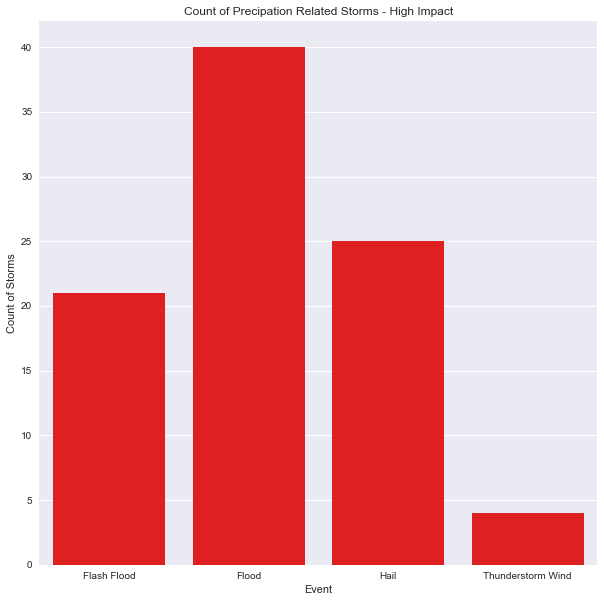

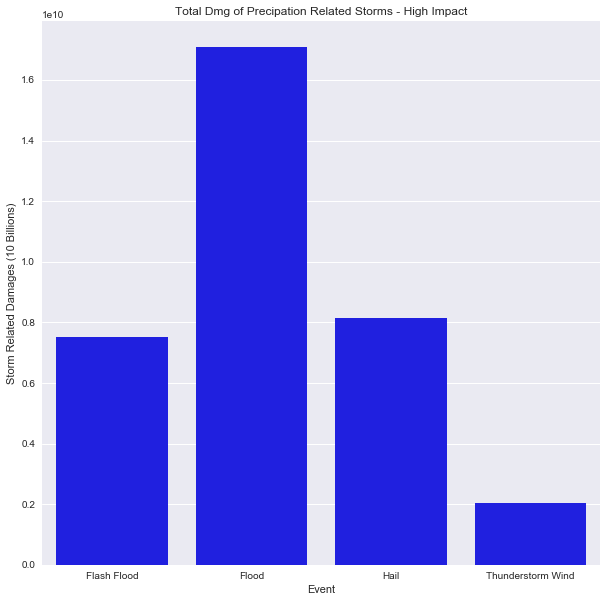

In [82]:
#Look at events that caused over a hundred million dollars worth of damages to get a better idea of what is causing the large losses.
High_impact_storm = pd.read_sql_query('SELECT Event, Count(Event), SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total_Dmg" FROM storm_data \
                  WHERE (Prop_Dmg + Crop_DMG > 100000000) AND (Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning") \
                  GROUP BY Event', engine)

#Bar plot of counts
sns.barplot(x=High_impact_storm['Event'], y=High_impact_storm["Count(Event)"],color="red")
plt.title("Count of Precipation Related Storms - High Impact")
plt.ylabel("Count of Storms")
plt.show()

#Bar plot of total damages
sns.barplot(x=High_impact_storm['Event'], y=High_impact_storm["Total_Dmg"],color="blue")
plt.title("Total Dmg of Precipation Related Storms - High Impact")
plt.ylabel("Storm Related Damages (10 Billions)")
plt.show()

#At over 100 million worth of damages the count becomes proportional to the total damages caused. Floods the most common by far.

We classified high impact storms as storms that caused over 100 million dollars worth of damages. The count for these type of storms was proportional to the proportion of total damages caused. Here, floods were counted over 150% more than the next highest storm type, hail. With this classification there were no storms under the event tags 'thunderstorms' or 'lightning'. Reasons for the dramatic change in distribution for high impact storms is that crops and infrastructure are not heavily affected by lighting and heavy rains. On the flip side, infrastructure is unable to withstand the destructiveness of floods, which wipe out everything in a given area. As such, when people are taking into account risk of storms they should primarily focus on flooding and hail. 

This information is useful for insurance companies, government works programs, and construction companies. Knowing what types of storms happen in what region can allow for these individuals to more adequately plan for highly sporadic events. For instance, knowing the vast amount of damage floods cause means that programs and workers can target preventative programs such as dams or levees to minimize the chance of a flood to occur. Alternatively, people in high-risk areas can acquire insurance to minimize their exposure to risk.

In [83]:
#Want to narrow down events to those that were most consistent with large amount of precipitation (i.e. floods, flash flood, and heavy rain). Don't include hail since hail is different than rain and also hail clusters in certain areas of the map making the map hard to read. Start at total damages over 10000 to include all values that cause at least a minor amount of damages.
High_impact_rain_related_dmgs = pd.read_sql_query('SELECT * FROM storm_data \
    WHERE (Prop_Dmg + Crop_DMG >= 10000) AND (Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain")', engine)

/Users/Ricky/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/Ricky/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/Ricky/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


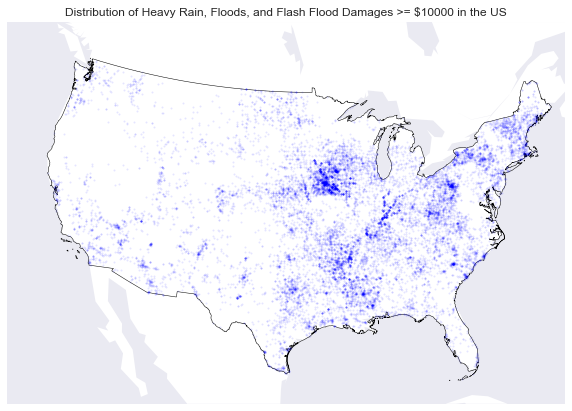

In [84]:
#Use base map to plot all the lon and lat of all the events listed above.
us_map = Basemap(llcrnrlon=-121,llcrnrlat=20,urcrnrlon=-62,urcrnrlat=51, projection='lcc',lat_1=32,lat_2=45,lon_0=-95)
us_map.readshapefile("/Users/Ricky/Desktop/cb_2015_us_nation_5m/cb_2015_us_nation_5m", "cb_2015_us_nation_5m")
us_map.fillcontinents(color="white")

for lon, lat in zip(High_impact_rain_related_dmgs.Lon, High_impact_rain_related_dmgs.Lat):
    x, y = us_map(lon, lat)  
    us_map.plot(x, y, 'b' + 'o', markersize = 2, alpha=.1)

plt.title("Distribution of Heavy Rain, Floods, and Flash Flood Damages >= $10000 in the US")
plt.show()

We decided to minimize the amount of events located on the graph to reflect events that are affected by excessive precipitation, such as heavy rainfall, floods, and flash floods. To this end, we subsetted based on total damages <b>greater than or equal to 10,000 dollars</b>, and the results suggest that there are significantly more storms in the northeast and central parts of the US. While this may be true, we have reason to believe that the reason for more storm recordings in these regions are due to significantly more people being present in these regions. With more people in an area there is a higher likelihood of people coming forward to claim a loss. Another possible reason for more damages located in the central and eastern parts of the US is the age of the infrastructure. Older buildings are more easily damaged by excessive rain or flooding, meaning that these buildings will incur more damages. Exploring the flooding and heavy rain location, there appears to be flooding along river lines, such as the Mississippi and Ohio Rivers. Therefore, the presence of rivers could affect flooding events, as the river could overflow and damage the surrounding area significantly more than a smaller body of water or a lake that has more defined boundaries and precautions against flooding. Overall, we believe that there is some bias within this data, since examining the map with more events results in heavy clustering around specific regions, such as Iowa. Thus, we have reason to believe that the NOAA headquarters or location distribution could affect how the damages are recorded. 

### Conclusion

Overall, essentially no correlation between ONI (and therefore El Nino) and precipitation or temperature fluctuations was found in any of the U.S. cities selected, for any time scale or form of precipitation data. However, out of 16, 4 U.S. cities show significant increases, and 2 show significant decreases in annual precipitation from 1950 to 2016, but no geographical link between these cities makes logical sense, respectively. In addition, there is evidence that global warming/climate change is, in fact, real; all sixteen U.S. cities studied show a significant increase, between 1 to 4 degrees Fahrenheit, in average recorded temperature from 1950 to 2016, but, again, there is no significant geographical link between the cities that show the most evidence of increase. Further studies can scrape data from more cities in the U.S. and even some around the Pacific Rim to make further conclusions on El Nino/La Nina. Also, it would be interesting to continue working with the premise of global warming to investigate trends in other nations. 

<b>R Code</b> can be located under the code section of pickeringsafran141b github repository as elnino.R.

<b> Quick disclaimer: </b> We tried closing the SQL database but due to the way that we transferred the pd dataframe to the SQL database we could not figure out how to close the session. We tried using engine.close() but Google told me that the engine is a tool used by SQL to act as an enabler for SQL and so that you don't close that. We then tried closing the storm_data, but that got an error message. Lastly, we tried closing the storm_sql, but that is a dataframe so that wouldn't close. Nothing we looked up on google matched what I had and since what we have works we did not want to try to transform my code to something on stackoverflow that we was not sure if it would work.

#### Project Contributions:

<b>Richard Safran:</b> Data munging with JSON/CSV extraction and HTML web scraping, data cleaning, SQL database creation/querying.

<b>Chad Pickering:</b> Exploratory analysis, time series and categorical data analysis, plots/graphics, report writing/presentation.